In [2]:
import pandas as pd
from transformers import BertTokenizer
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print(f"Vocab size: {tokenizer.vocab_size:,}")

Vocab size: 30,522


In [3]:
sample_tweets = [
    "I love this product! 😍",
    "This is terrible 😠",
    "Not sure if I like it...",
    "OMG best thing ever!!!",
    "Worst experience of my life"
]
for tweet in sample_tweets:
    print(f"\nOriginal: {tweet}")
    tokens = tokenizer.tokenize(tweet)
    print(f"Tokens:   {tokens}")
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    print(f"IDs:      {token_ids}")
    encoded = tokenizer.encode(tweet, add_special_tokens=True)
    print(f"Encoded:  {encoded}")
    decoded = tokenizer.decode(encoded)
    print(f"Decoded:  {decoded}")


Original: I love this product! 😍
Tokens:   ['i', 'love', 'this', 'product', '!', '[UNK]']
IDs:      [1045, 2293, 2023, 4031, 999, 100]
Encoded:  [101, 1045, 2293, 2023, 4031, 999, 100, 102]
Decoded:  [CLS] i love this product! [UNK] [SEP]

Original: This is terrible 😠
Tokens:   ['this', 'is', 'terrible', '[UNK]']
IDs:      [2023, 2003, 6659, 100]
Encoded:  [101, 2023, 2003, 6659, 100, 102]
Decoded:  [CLS] this is terrible [UNK] [SEP]

Original: Not sure if I like it...
Tokens:   ['not', 'sure', 'if', 'i', 'like', 'it', '.', '.', '.']
IDs:      [2025, 2469, 2065, 1045, 2066, 2009, 1012, 1012, 1012]
Encoded:  [101, 2025, 2469, 2065, 1045, 2066, 2009, 1012, 1012, 1012, 102]
Decoded:  [CLS] not sure if i like it... [SEP]

Original: OMG best thing ever!!!
Tokens:   ['om', '##g', 'best', 'thing', 'ever', '!', '!', '!']
IDs:      [18168, 2290, 2190, 2518, 2412, 999, 999, 999]
Encoded:  [101, 18168, 2290, 2190, 2518, 2412, 999, 999, 999, 102]
Decoded:  [CLS] omg best thing ever!!! [SEP]

Orig

In [4]:
long_tweet = "I absolutely love this product! It's amazing and exceeded all my expectations. Highly recommend to everyone!"
for max_length in [16, 32, 64]:
    encoded = tokenizer.encode_plus(
        long_tweet,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    print(f"\nMax length: {max_length}")
    print(f"Input IDs shape: {encoded['input_ids'].shape}")
    print(f"Attention mask shape: {encoded['attention_mask'].shape}")
    print(f"Input IDs: {encoded['input_ids'][0][:20]}...")


Max length: 16
Input IDs shape: torch.Size([1, 16])
Attention mask shape: torch.Size([1, 16])
Input IDs: tensor([  101,  1045,  7078,  2293,  2023,  4031,   999,  2009,  1005,  1055,
         6429,  1998, 14872,  2035,  2026,   102])...

Max length: 32
Input IDs shape: torch.Size([1, 32])
Attention mask shape: torch.Size([1, 32])
Input IDs: tensor([  101,  1045,  7078,  2293,  2023,  4031,   999,  2009,  1005,  1055,
         6429,  1998, 14872,  2035,  2026, 10908,  1012,  3811, 16755,  2000])...

Max length: 64
Input IDs shape: torch.Size([1, 64])
Attention mask shape: torch.Size([1, 64])
Input IDs: tensor([  101,  1045,  7078,  2293,  2023,  4031,   999,  2009,  1005,  1055,
         6429,  1998, 14872,  2035,  2026, 10908,  1012,  3811, 16755,  2000])...


In [5]:
train_df = pd.read_csv('../data/processed/train.csv')
print(f"Analyzing {len(train_df):,} tweets...")
token_lengths = []
for text in train_df['text_clean'].head(1000):
    tokens = tokenizer.tokenize(str(text))
    token_lengths.append(len(tokens))

Analyzing 79,817 tweets...


In [6]:
import numpy as np
token_lengths = np.array(token_lengths)

print(f"\nToken length statistics:")
print(f"Mean:   {token_lengths.mean():.1f}")
print(f"Median: {np.median(token_lengths):.1f}")
print(f"Max:    {token_lengths.max()}")
print(f"Min:    {token_lengths.min()}")
print(f"95th percentile: {np.percentile(token_lengths, 95):.1f}")
recommended_max_length = int(np.percentile(token_lengths, 95)) + 5
print(f"\nRecommended max_length: {recommended_max_length}")


Token length statistics:
Mean:   17.1
Median: 16.0
Max:    69
Min:    1
95th percentile: 33.0

Recommended max_length: 38


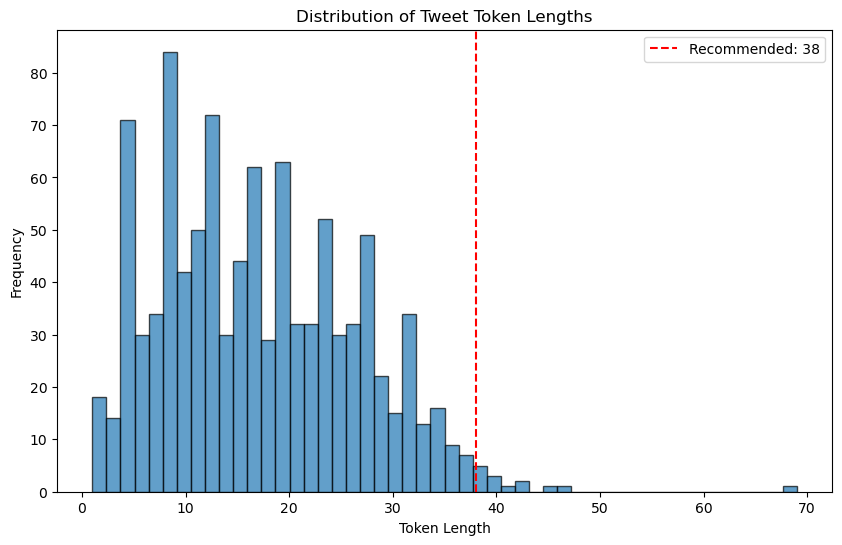

We'll use max_length=38 for training


In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(recommended_max_length, color='red', linestyle='--', 
            label=f'Recommended: {recommended_max_length}')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Distribution of Tweet Token Lengths')
plt.legend()
plt.savefig('../results/plots/token_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"We'll use max_length={recommended_max_length} for training")